# “不安全”的 MP2 Hessian

这一节，我们会介绍“不安全”的 MP2 Hessian 的求解过程。这非常接近 pyxdh 所实际采用的计算流程；但我们将所有涉及到 $\mathscr{U}_{pq}^{A_t}$ 之处，全部替换为了 $U_{pq}^{A_t}$。尽管我们会提及二阶 U 矩阵 $U_{pq}^{A_t B_s}$，但在实际计算中会依靠逆向 Z-Vector 方法，尽量避免使用它。

## 准备工作

<div class="alert alert-warning">

**程序变量名变更**

出于程序简便的考量，这一节中特别地，所有 `U_1` 代表的不是 $\mathscr{U}_{pq}^\mathbb{A}$，而是原先用 `U_1_nr` 所指代的未经轨道旋转的 $U_{pq}^\mathbb{A}$。

类似地，`gradh_nr` 会被 `gradh`，`hessh_nr` 会被 `hessh` 替代。

</div>

我们这里同时引入 A 张量一阶导数量的缩并函数 `Ax1_Core`；它从使用上与 `Ax0_Core` 相同，但关于维度上，$A_{pq, rs}^\mathbb{A} X_{rs}^\mathbb{B}$ 在对 $r, s$ 角标缩并后给出的结果是 $(\mathbb{A}, \mathbb{B}, p, q)$ 维度的。

In [1]:
%matplotlib notebook

from pyscf import gto, scf, dft, lib, grad, hessian
from pyscf.scf import cphf
import numpy as np
from functools import partial
import warnings
from matplotlib import pyplot as plt
from pyxdh.Utilities import NucCoordDerivGenerator, DipoleDerivGenerator, NumericDiff
from pyxdh.DerivOnce import GradMP2
from pyxdh.DerivTwice import HessMP2, HessSCF

np.einsum = partial(np.einsum, optimize=["greedy", 1024 ** 3 * 2 / 8])
np.allclose = partial(np.allclose, atol=1e-6, rtol=1e-4)
np.set_printoptions(5, linewidth=150, suppress=True)
warnings.filterwarnings("ignore")

In [2]:
mol = gto.Mole()
mol.atom = """
O  0.0  0.0  0.0
O  0.0  0.0  1.5
H  1.0  0.0  0.0
H  0.0  0.7  1.0
"""
mol.basis = "6-31G"
mol.verbose = 0
mol.build()

In [3]:
gradh = GradMP2({"scf_eng": scf.RHF(mol), "cphf_tol": 1e-12, "rotation": False})
hessh = HessMP2({"deriv_A": gradh, "deriv_B": gradh, "rotation": False})

In [4]:
nmo, nao, natm, nocc, nvir = gradh.nao, gradh.nao, gradh.natm, gradh.nocc, gradh.nvir
so, sv, sa = gradh.so, gradh.sv, gradh.sa
mol_slice = gradh.mol_slice
C, Co, Cv, e, eo, ev, D = gradh.C, gradh.Co, gradh.Cv, gradh.e, gradh.eo, gradh.ev, gradh.D
H_0_ao, S_0_ao, eri0_ao, F_0_ao = gradh.H_0_ao, gradh.S_0_ao, gradh.eri0_ao, gradh.F_0_ao
H_0_mo, S_0_mo, eri0_mo, F_0_mo = gradh.H_0_mo, gradh.S_0_mo, gradh.eri0_mo, gradh.F_0_mo
H_1_ao, S_1_ao, eri1_ao, F_1_ao = gradh.H_1_ao, gradh.S_1_ao, gradh.eri1_ao, gradh.F_1_ao
H_1_mo, S_1_mo, eri1_mo, F_1_mo = gradh.H_1_mo, gradh.S_1_mo, gradh.eri1_mo, gradh.F_1_mo
Ax0_Core, B_1, U_1, U_1_vo = gradh.Ax0_Core, gradh.B_1, gradh.U_1, gradh.U_1_vo
H_2_ao, S_2_ao, eri2_ao, F_2_ao = hessh.H_2_ao, hessh.S_2_ao, hessh.eri2_ao, hessh.F_2_ao
H_2_mo, S_2_mo, eri2_mo, F_2_mo = hessh.H_2_mo, hessh.S_2_mo, hessh.eri2_mo, hessh.F_2_mo
Ax1_Core, B_2, U_2 = gradh.Ax1_Core, hessh.B_2, hessh.U_2

In [5]:
T_iajb, t_iajb, D_iajb = gradh.T_iajb, gradh.t_iajb, gradh.D_iajb
D_r, W_I = gradh.D_r, gradh.W_I

In [6]:
def grad_generator(mol):
    scf_eng = scf.RHF(mol)
    config = {"scf_eng": scf_eng, "cphf_tol": 1e-12, "rotation": False}
    return GradMP2(config)

gradn = NucCoordDerivGenerator(mol, grad_generator)

In [7]:
def plot_diff(anal_mat, num_mat):
    fig, ax = plt.subplots(figsize=(2.4, 1.8)); ax.set_xscale("log")
    ax.hist(abs(anal_mat.ravel() - num_mat.ravel()), bins=np.logspace(np.log10(1e-10), np.log10(1e-1), 50), alpha=0.5)
    ax.hist(abs(num_mat.ravel()), bins=np.logspace(np.log10(1e-10), np.log10(1e-1), 50), alpha=0.5)
    return fig.tight_layout()

## 程序二阶导数正确性的验证

首先，MP2 的二阶导数可以通过 `E_2` property 获得：

In [8]:
hessh.E_2.shape

(12, 12)

Gaussian 程序可以计算 MP2 的二阶导数。其 [输入卡](https://github.com/ajz34/Py_xDH/blob/master/pyxdh/Validation/gaussian/H2O2-MP2-freq.gjf) 与 [fchk 文件](https://github.com/ajz34/Py_xDH/blob/master/pyxdh/Validation/gaussian/H2O2-MP2-freq.fchk) 可以前往 Github 上下载。我们这里拿现成的程序验证之：

In [9]:
from pyxdh.Utilities import FormchkInterface

In [10]:
fchk_MP2 = FormchkInterface("../../../pyxdh/Validation/gaussian/H2O2-MP2-freq.fchk")  # if use Py_xDH repository, this link should be valid
np.allclose(hessh.E_2, fchk_MP2.hessian())

True

其 RHF 部分的 Hessian 可以由下面导出：

In [11]:
E_2_RHF_contrib = HessSCF._get_E_2(hessh)
E_2_RHF_contrib.shape

(12, 12)

In [12]:
fchk_RHF = FormchkInterface("../../../pyxdh/Validation/gaussian/H2O2-HF-freq.fchk")  # if use Py_xDH repository, this link should be valid
np.allclose(E_2_RHF_contrib, fchk_RHF.hessian())

True

而 MP2 部分的 Hessian 则由下式导出：

In [13]:
E_2_MP2_contrib = hessh._get_E_2_MP2_Contrib()
E_2_MP2_contrib.shape

(12, 12)

两部分的加和即是总 Hessian：

In [14]:
np.allclose(E_2_RHF_contrib + E_2_MP2_contrib, hessh.E_2)

True

我们文档的目标，将是生成 `E_2_MP2_contrib` $\partial_\mathbb{A} \partial_\mathbb{B} E_\mathrm{MP2, c}$。

## MP2 二阶梯度概述

回顾到

$$
\partial_\mathbb{A} E_\mathrm{MP2, c} = D_{pq}^\mathrm{MP2} B_{pq}^\mathbb{A} + W_{pq}^\mathrm{MP2} [\mathrm{I}] S_{pq}^\mathbb{A} + 2 T_{ij}^{ab} (ia | jb)^\mathbb{A}
$$

我们需要做的，仅仅是将链式法则用于上式中。

$$
\begin{align}
\partial_\mathbb{A} \partial_\mathbb{B} E_\mathrm{MP2, c}
&= \partial_\mathbb{B} D_{pq}^\mathrm{MP2} \cdot B_{pq}^\mathbb{A} + D_{pq}^\mathrm{MP2} \cdot \partial_\mathbb{B} B_{pq}^\mathbb{A} \\
&\quad + \partial_\mathbb{B} W_{pq}^\mathrm{MP2} [\mathrm{I}] \cdot S_{pq}^\mathbb{A} + W_{pq}^\mathrm{MP2} [\mathrm{I}] \cdot \partial_\mathbb{B} S_{pq}^\mathbb{A} \\
&\quad + 2 \partial_\mathbb{B} T_{ij}^{ab} \cdot (ia | jb)^\mathbb{A} + 2 T_{ij}^{ab} \cdot \partial_\mathbb{B} (ia | jb)^\mathbb{A}
\end{align}
$$

我们简单讨论一下上面的表达式。在给定未经轨道旋转的 U 矩阵的情况下，首先，$\partial_\mathbb{B} S_{pq}^\mathbb{A}$ 与 $\partial_\mathbb{B} (ia | jb)^\mathbb{A}$  是容易求取的。$\partial_\mathbb{B} B_{pq}^\mathbb{A}$ 需要使用到 $A_{pq, kl}^\mathbb{A}$，这我们在上一节也讨论过了。因此，右侧的三项就不是很困难的问题。

对于左边的三项而言，首先，$W_{pq}^\mathrm{MP2} [\mathrm{I}]$，$T_{ij}^{ab}$ 与 $D_{ij}^\mathrm{MP2}$, $D_{ab}^\mathrm{MP2}$ 都需要 $t_{ij}^{ab}$，因此需要计算 $t_{ij}^{ab}$ 的全导数。除此之外，$D_{ai}^\mathrm{MP2}$ 的推导是通过 CP-HF 方程给出的，因此它的求导也需要技巧。

## `pdB_B_A` $\partial_\mathbb{B} B_{pq}^\mathbb{A}$ 与 `pdB_S_A_mo` $\partial_\mathbb{B} S_{pq}^\mathbb{A}$

回顾 $B_{pq}^\mathbb{A}$ 的定义：

$$
B_{pq}^\mathbb{A} = F_{pq}^\mathbb{A} - S_{pq}^\mathbb{A} \varepsilon_q - \frac{1}{2} A_{pq, kl} S_{kl}^\mathbb{A}
$$

我们之后会重述该 B 矩阵为

$$
B_{pq}^\mathbb{A} = F_{pq}^\mathbb{A} - S_{pm}^\mathbb{A} F_{qm} - \frac{1}{2} A_{pq, kl} S_{kl}^\mathbb{A}
$$

我们求取上述导数的方式也很暴力：

$$
\begin{align}
\partial_\mathbb{B} B_{pq}^\mathbb{A}
&= \partial_\mathbb{B} F_{pq}^\mathbb{A} - \partial_\mathbb{B} S_{pm}^\mathbb{A} \cdot F_{qm} - S_{pm}^\mathbb{A} \cdot \partial_\mathbb{B} F_{qm} - \frac{1}{2} A_{pq, kl} \cdot \partial_\mathbb{B} S_{kl}^\mathbb{A} - \frac{1}{2} A_{pq, kl}^\mathbb{B} S_{kl}^\mathbb{A} \\
&\quad - A_{pq, mk} U_{ml}^\mathbb{B} S_{kl}^\mathbb{A} - \frac{1}{2} A_{pm, kl} S_{kl}^\mathbb{A} U_{mq}^\mathbb{B} - \frac{1}{2} A_{mq, kl} S_{kl}^\mathbb{A} U_{mp}^\mathbb{B}
\end{align}
$$

我们给出一些中间变量：

- `pdB_F_A_mo` $\partial_\mathbb{B} F_{pq}^\mathbb{A}$：

$$
\partial_\mathbb{B} F_{pq}^\mathbb{A} = F_{pq}^\mathbb{AB} + A_{pq, mk}^\mathbb{A} U_{mk}^\mathbb{B} + F_{pm}^\mathbb{A} U_{mq}^\mathbb{B} + F_{mq}^\mathbb{A} U_{mp}^\mathbb{B}
$$

In [15]:
pdB_F_A_mo = (
    + F_2_mo
    + Ax1_Core(sa, sa, sa, so)(U_1[:, :, so])
    + np.einsum("Apm, Bmq -> ABpq", F_1_mo, U_1)
    + np.einsum("Amq, Bmp -> ABpq", F_1_mo, U_1)
)
pdB_F_A_mo.shape

(12, 12, 22, 22)

<IPython.core.display.Javascript object>


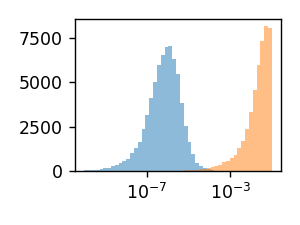

In [16]:
nd_F_1_mo = NumericDiff(gradn, lambda gradh: gradh.F_1_mo).derivative.swapaxes(0, 1)
plot_diff(pdB_F_A_mo, nd_F_1_mo)

In [17]:
np.allclose(pdB_F_A_mo, hessh.pdB_F_A_mo)  # pyxdh approach

True

- `pdB_S_A_mo` $\partial_\mathbb{B} S_{pq}^\mathbb{A}$

$$
\partial_\mathbb{B} S_{pq}^\mathbb{A} = S_{pq}^\mathbb{AB} + S_{pm}^\mathbb{A} U_{mq}^\mathbb{B} + S_{mq}^\mathbb{A} U_{mp}^\mathbb{B}
$$

In [18]:
pdB_S_A_mo = (
    + S_2_mo
    + np.einsum("Apm, Bmq -> ABpq", S_1_mo, U_1)
    + np.einsum("Amq, Bmp -> ABpq", S_1_mo, U_1)
)
pdB_S_A_mo.shape

(12, 12, 22, 22)

<IPython.core.display.Javascript object>


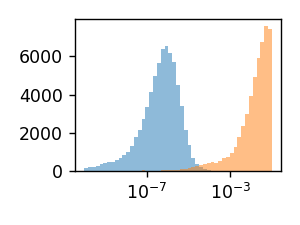

In [19]:
nd_S_1_mo = NumericDiff(gradn, lambda gradh: gradh.S_1_mo).derivative.swapaxes(0, 1)
plot_diff(pdB_S_A_mo, nd_S_1_mo)

In [20]:
np.allclose(pdB_S_A_mo, hessh.pdB_S_A_mo)  # pyxdh approach

True

- `pdA_F_0_mo` $\partial_\mathbb{A} F_{pq}$

$$
\partial_\mathbb{A} F_{pq} = F_{pq}^\mathbb{A} + A_{pq, mk} U_{mk}^\mathbb{A} + F_{pm} U_{mq}^\mathbb{A} + F_{mq} U_{mp}^\mathbb{A}
$$

In [21]:
pdA_F_0_mo = (
    + F_1_mo
    + Ax0_Core(sa, sa, sa, so)(U_1[:, :, so])
    + np.einsum("pm, Amq -> Apq", F_0_mo, U_1)
    + np.einsum("mq, Amp -> Apq", F_0_mo, U_1)
)
pdA_F_0_mo.shape

(12, 22, 22)

<IPython.core.display.Javascript object>


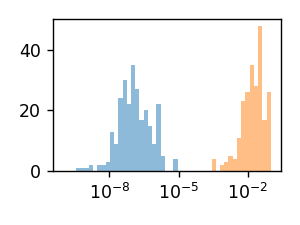

In [22]:
nd_F_0_mo = NumericDiff(gradn, lambda gradh: gradh.F_0_mo).derivative
plot_diff(pdA_F_0_mo.diagonal(axis1=-2, axis2=-1), nd_F_0_mo.diagonal(axis1=-2, axis2=-1))

- `pdB_B_A` $\partial_\mathbb{B} B_{pq}^\mathbb{A}$

$$
\begin{align}
\partial_\mathbb{B} B_{pq}^\mathbb{A}
&= \partial_\mathbb{B} F_{pq}^\mathbb{A} - \partial_\mathbb{B} S_{pm}^\mathbb{A} \cdot F_{qm} - S_{pm}^\mathbb{A} \cdot \partial_\mathbb{B} F_{qm} - \frac{1}{2} A_{pq, kl} \cdot \partial_\mathbb{B} S_{kl}^\mathbb{A} - \frac{1}{2} A_{pq, kl}^\mathbb{B} S_{kl}^\mathbb{A} \\
&\quad - A_{pq, mk} U_{ml}^\mathbb{B} S_{kl}^\mathbb{A} - \frac{1}{2} A_{pm, kl} S_{kl}^\mathbb{A} U_{mq}^\mathbb{B} - \frac{1}{2} A_{mq, kl} S_{kl}^\mathbb{A} U_{mp}^\mathbb{B}
\end{align}
$$

In [23]:
pdB_B_A = (
    + pdB_F_A_mo
    - np.einsum("ABpm, qm -> ABpq", pdB_S_A_mo, F_0_mo)
    - np.einsum("Apm, Bqm -> ABpq", S_1_mo, pdA_F_0_mo)
    - 0.5 * Ax0_Core(sa, sa, so, so)(pdB_S_A_mo[:, :, so, so])
    - 0.5 * Ax1_Core(sa, sa, so, so)(S_1_mo[:, so, so]).swapaxes(0, 1)
    - Ax0_Core(sa, sa, sa, so)(np.einsum("Bml, Akl -> ABmk", U_1[:, :, so], S_1_mo[:, so, so]))
    - 0.5 * np.einsum("Apm, Bmq -> ABpq", Ax0_Core(sa, sa, so, so)(S_1_mo[:, so, so]), U_1)
    - 0.5 * np.einsum("Amq, Bmp -> ABpq", Ax0_Core(sa, sa, so, so)(S_1_mo[:, so, so]), U_1)
)
pdB_B_A.shape

(12, 12, 22, 22)

<IPython.core.display.Javascript object>


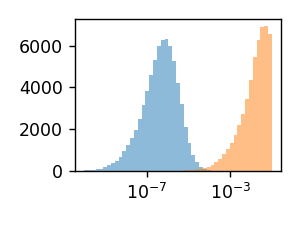

In [24]:
nd_B_1 = NumericDiff(gradn, lambda gradh: gradh.B_1).derivative.swapaxes(0, 1)
plot_diff(pdB_B_A, nd_B_1)

In [25]:
np.allclose(pdB_B_A, hessh.pdB_B_A)  # pyxdh approach

True

## `pdB_pdpA_eri0_iajb` $\partial_\mathbb{B} (ia | jb)^\mathbb{A}$

- `pdB_pdpA_eri0_iajb` $\partial_\mathbb{B} (ia | jb)^\mathbb{A}$

$$
\partial_\mathbb{B} (ia | jb)^\mathbb{A} = (ia | jb)^\mathbb{AB} + (ma | jb)^\mathbb{A} U_{mi}^\mathbb{B} + (im | jb)^\mathbb{A} U_{ma}^\mathbb{B} + (ia | mb)^\mathbb{A} U_{mj}^\mathbb{B} + (ia | jm)^\mathbb{A} U_{mb}^\mathbb{B}
$$

In [26]:
pdB_pdpA_eri0_iajb = (
    + np.einsum("ABuvkl, ui, va, kj, lb -> ABiajb", eri2_ao, Co, Cv, Co, Cv)
    + np.einsum("Amajb, Bmi -> ABiajb", eri1_mo[:, :, sv, so, sv], U_1[:, :, so])
    + np.einsum("Aimjb, Bma -> ABiajb", eri1_mo[:, so, :, so, sv], U_1[:, :, sv])
    + np.einsum("Aiamb, Bmj -> ABiajb", eri1_mo[:, so, sv, :, sv], U_1[:, :, so])
    + np.einsum("Aiajm, Bmb -> ABiajb", eri1_mo[:, so, sv, so, :], U_1[:, :, sv])
)

<IPython.core.display.Javascript object>


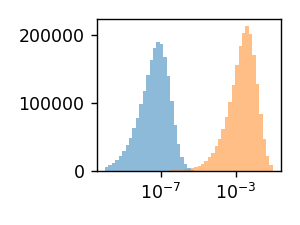

In [27]:
nd_eri1_mo = NumericDiff(gradn, lambda gradh: gradh.eri1_mo[:, so, sv, so, sv]).derivative.swapaxes(0, 1)
plot_diff(pdB_pdpA_eri0_iajb, nd_eri1_mo)

## `pdA_t_iajb` $\partial_\mathbb{A} t_{ij}^{ab}$

该导数的求取方式相对来说特别一些。首先，我们根据链式法则，容易给出如下表达式：

$$
\partial_\mathbb{A} t_{ij}^{ab} = \big( - \partial_\mathbb{A} D_{ij}^{ab} \cdot t_{ij}^{ab} + \partial_\mathbb{A} (ia|jb) \big) / D_{ij}^{ab}
$$

其中，$\partial_\mathbb{A} (ia|jb)$ 是相对容易求的。但对于 $\partial_\mathbb{A} D_{ij}^{ab} \cdot t_{ij}^{ab}$，我们会重新写为

$$
\partial_\mathbb{A} D_{ij}^{ab} \cdot t_{ij}^{ab} = \partial_\mathbb{A} F_{ki} \cdot t_{kj}^{ab} + \partial_\mathbb{A} F_{kj} \cdot t_{ik}^{ab} - \partial_\mathbb{A} F_{ca} \cdot t_{ij}^{cb} - \partial_\mathbb{A} F_{cb} \cdot t_{ij}^{ac}
$$

- `pdA_eri0_mo` $\partial_\mathbb{A} (pq|rs)$

$$
\partial_\mathbb{A} (pq|rs) = (pq|rs)^\mathbb{A} + (mq|rs) U_{mp}^\mathbb{A} + (pm|rs) U_{mq}^\mathbb{A} + (pq|ms) U_{mr}^\mathbb{A} + (pq|rm) U_{ms}^\mathbb{A}
$$

In [28]:
pdA_eri0_mo = (
    + eri1_mo
    + np.einsum("mqrs, Amp -> Apqrs", eri0_mo, U_1)
    + np.einsum("pmrs, Amq -> Apqrs", eri0_mo, U_1)
    + np.einsum("pqms, Amr -> Apqrs", eri0_mo, U_1)
    + np.einsum("pqrm, Ams -> Apqrs", eri0_mo, U_1)
)

<IPython.core.display.Javascript object>


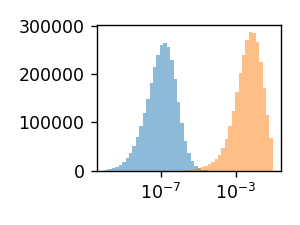

In [29]:
nd_eri0_mo = NumericDiff(gradn, lambda gradh: gradh.eri0_mo).derivative
plot_diff(pdA_eri0_mo, nd_eri0_mo)

In [30]:
np.allclose(pdA_eri0_mo, gradh.pdA_eri0_mo)  # pyxdh approach

True

- `pdA_t_iajb` $\partial_\mathbb{A} t_{ij}^{ab}$

$$
\partial_\mathbb{A} t_{ij}^{ab} = \big( \partial_\mathbb{A} (ia|jb) - \partial_\mathbb{A} F_{ki} \cdot t_{kj}^{ab} - \partial_\mathbb{A} F_{kj} \cdot t_{ik}^{ab} + \partial_\mathbb{A} F_{ca} \cdot t_{ij}^{cb} + \partial_\mathbb{A} F_{cb} \cdot t_{ij}^{ac} \big) / D_{ij}^{ab}
$$

In [31]:
pdA_t_iajb = (
    + pdA_eri0_mo[:, so, sv, so, sv]
    - np.einsum("Aki, kajb -> Aiajb", pdA_F_0_mo[:, so, so], t_iajb)
    - np.einsum("Akj, iakb -> Aiajb", pdA_F_0_mo[:, so, so], t_iajb)
    + np.einsum("Aca, icjb -> Aiajb", pdA_F_0_mo[:, sv, sv], t_iajb)
    + np.einsum("Acb, iajc -> Aiajb", pdA_F_0_mo[:, sv, sv], t_iajb)
)
pdA_t_iajb /= D_iajb

<IPython.core.display.Javascript object>


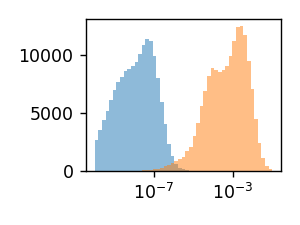

In [32]:
nd_t_iajb = NumericDiff(gradn, lambda gradh: gradh.t_iajb).derivative
plot_diff(pdA_t_iajb, nd_t_iajb)

In [33]:
np.allclose(pdA_t_iajb, gradh.pdA_t_iajb)  # pyxdh approach

True

## 包含 $\partial_\mathbb{A} t_{ij}^{ab}$ 的各类导数

### `pdA_T_iajb` $\partial_\mathbb{A} T_{ij}^{ab}$

回顾到 (在 RHF 参考态下)

$$
T_{ij}^{ab} = 2 t_{ij}^{ab} - t_{ij}^{ba}
$$

因此

$$
\partial_\mathbb{A} T_{ij}^{ab} = 2 \partial_\mathbb{A} t_{ij}^{ab} - \partial_\mathbb{A} t_{ij}^{ba}
$$

In [34]:
pdA_T_iajb = 2 * pdA_t_iajb - pdA_t_iajb.swapaxes(-1, -3)
pdA_T_iajb.shape

(12, 9, 13, 9, 13)

<IPython.core.display.Javascript object>


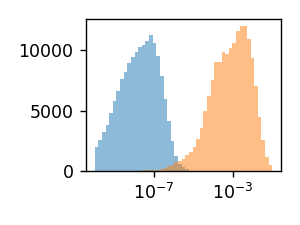

In [35]:
nd_T_iajb = NumericDiff(gradn, lambda gradh: gradh.T_iajb).derivative
plot_diff(pdA_T_iajb, nd_T_iajb)

In [36]:
np.allclose(pdA_T_iajb, gradh.pdA_T_iajb)  # pyxdh approach

True

### `pdB_D_r_oovv` $\partial_\mathbb{B} D_{pq}^\mathrm{MP2}$ 的占据-占据与非占-非占块

回顾弛豫密度的占据-占据与非占-非占块的计算：

$$
\begin{aligned}
D_{ij}^\text{PT2} &= - 2 T_{ik}^{ab} t_{jk}^{ab} \\
D_{ab}^\text{PT2} &= 2 T_{ij}^{ac} t_{ij}^{bc}
\end{aligned}
$$

这也相当容易用链式法则给出其计算方式：

$$
\begin{aligned}
\partial_\mathbb{B} D_{ij}^\text{PT2} &= - 2 \partial_\mathbb{B} T_{ik}^{ab} \cdot t_{jk}^{ab} - 2 T_{ik}^{ab} \cdot \partial_\mathbb{B} t_{jk}^{ab} \\
\partial_\mathbb{B} D_{ab}^\text{PT2} &= 2 \partial_\mathbb{B} T_{ij}^{ac} \cdot t_{ij}^{bc} + 2 T_{ij}^{ac} \cdot \partial_\mathbb{B} t_{ij}^{bc}
\end{aligned}
$$

In [37]:
pdB_D_r_oovv = np.zeros((natm * 3, nmo, nmo))
pdB_D_r_oovv[:, so, so] -= 2 * np.einsum("iakb, Ajakb -> Aij", T_iajb, pdA_t_iajb)
pdB_D_r_oovv[:, sv, sv] += 2 * np.einsum("iajc, Aibjc -> Aab", T_iajb, pdA_t_iajb)
pdB_D_r_oovv[:, so, so] -= 2 * np.einsum("Aiakb, jakb -> Aij", pdA_T_iajb, t_iajb)
pdB_D_r_oovv[:, sv, sv] += 2 * np.einsum("Aiajc, ibjc -> Aab", pdA_T_iajb, t_iajb)

In [38]:
nd_D_r = NumericDiff(gradn, lambda gradh: gradh.D_r).derivative

<IPython.core.display.Javascript object>


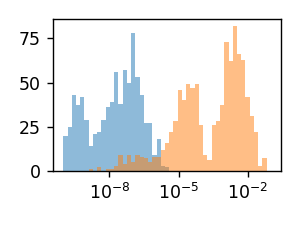

In [39]:
plot_diff(pdB_D_r_oovv[:, so, so], nd_D_r[:, so, so])

<IPython.core.display.Javascript object>


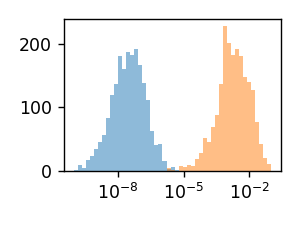

In [40]:
plot_diff(pdB_D_r_oovv[:, sv, sv], nd_D_r[:, sv, sv])

### `pdB_W_I` $\partial_\mathbb{B} W_{pq}^\mathrm{MP2}$

回顾到

$$
\begin{align}
W_{ij}^\mathrm{PT2} [\mathrm{I}] &= - 2 T_{ik}^{ab} (ja|kb) \\
W_{ab}^\mathrm{PT2} [\mathrm{I}] &= - 2 T_{ij}^{ac} (ib|jc) \\
W_{ai}^\mathrm{PT2} [\mathrm{I}] &= - 4 T_{jk}^{ab} (ij|bk) \\
W_{ia}^\mathrm{PT2} [\mathrm{I}] &= 0
\end{align}
$$

我们有

$$
\begin{align}
\partial_\mathbb{B} W_{ij}^\mathrm{PT2} [\mathrm{I}] &= - 2 \partial_\mathbb{B} T_{ik}^{ab} \cdot (ja|kb) - 2 T_{ik}^{ab} \cdot \partial_\mathbb{B} (ja|kb) \\
\partial_\mathbb{B} W_{ab}^\mathrm{PT2} [\mathrm{I}] &= - 2 \partial_\mathbb{B} T_{ij}^{ac} \cdot (ib|jc) - 2 T_{ij}^{ac} \cdot \partial_\mathbb{B} (ib|jc) \\
\partial_\mathbb{B} W_{ai}^\mathrm{PT2} [\mathrm{I}] &= - 4 \partial_\mathbb{B} T_{jk}^{ab} \cdot (ij|bk) - 4 T_{jk}^{ab} \cdot \partial_\mathbb{B} (ij|bk) \\
\partial_\mathbb{B} W_{ia}^\mathrm{PT2} [\mathrm{I}] &= 0
\end{align}
$$

In [41]:
pdB_W_I = np.zeros((natm * 3, nmo, nmo))
pdB_W_I[:, so, so] -= 2 * np.einsum("Aiakb, jakb -> Aij", pdA_T_iajb, eri0_mo[so, sv, so, sv])
pdB_W_I[:, sv, sv] -= 2 * np.einsum("Aiajc, ibjc -> Aab", pdA_T_iajb, eri0_mo[so, sv, so, sv])
pdB_W_I[:, sv, so] -= 4 * np.einsum("Ajakb, ijbk -> Aai", pdA_T_iajb, eri0_mo[so, so, sv, so])
pdB_W_I[:, so, so] -= 2 * np.einsum("iakb, Ajakb -> Aij", T_iajb, pdA_eri0_mo[:, so, sv, so, sv])
pdB_W_I[:, sv, sv] -= 2 * np.einsum("iajc, Aibjc -> Aab", T_iajb, pdA_eri0_mo[:, so, sv, so, sv])
pdB_W_I[:, sv, so] -= 4 * np.einsum("jakb, Aijbk -> Aai", T_iajb, pdA_eri0_mo[:, so, so, sv, so])

<IPython.core.display.Javascript object>


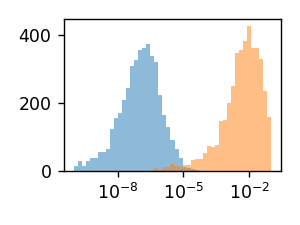

In [42]:
nd_W_I = NumericDiff(gradn, lambda gradh: gradh.W_I).derivative
plot_diff(pdB_W_I, nd_W_I)

In [43]:
np.allclose(pdB_W_I, hessh.pdB_W_I)  # pyxdh approach

True

## $\partial_\mathbb{B} D_{ai}^\mathrm{MP2}$ 的处理

### `pdB_D_r` $\partial_\mathbb{B} D_{ai}^\mathrm{MP2}$

首先，我们回顾到

$$
- (\varepsilon_a - \varepsilon_i) D_{ai}^\mathrm{MP2} - A_{ai, bj} D_{bj}^\mathrm{MP2} = L_{ai}^\mathrm{MP2}
$$

我们也会将上式重新写作

$$
F_{ki} D_{ak}^\mathrm{MP2} - F_{ca} D_{ci}^\mathrm{MP2} - A_{ai, bj} D_{bj}^\mathrm{MP2} = L_{ai}^\mathrm{MP2}
$$

我们对上述等式两边求导，得到

$$
\begin{align}
\partial_\mathbb{B} L_{ai}^\mathrm{MP2}
&= - (\varepsilon_a - \varepsilon_i) \cdot \partial_\mathbb{B} D_{ai}^\mathrm{MP2} - A_{ai, bj} \cdot \partial_\mathbb{B} D_{bj}^\mathrm{MP2} \\
&\quad + \partial_\mathbb{B} F_{ki} \cdot D_{ak}^\mathrm{MP2} - \partial_\mathbb{B} F_{ca} \cdot D_{ci}^\mathrm{MP2} - \partial_\mathbb{B} A_{ai, bj} \cdot D_{bj}^\mathrm{PT2}
\end{align}
$$

我们重新整理上式，就可以得到一个新的 CP-HF 方程。同时留意到

$$
\begin{align}
L_{ai} &= A_{ai, kl} D_{kl}^\mathrm{MP2} + A_{ai, bc} D_{bc}^\mathrm{MP2} - 4 T_{jk}^{ab} (ij|bk) + 4 T_{ij}^{bc} (ab|jc) \\
&= A_{ai, pq} D_{pq}^\text{MP2, oo-vv} - 4 T_{jk}^{ab} (ij|bk) + 4 T_{ij}^{bc} (ab|jc)
\end{align}
$$

我们能得到

$$
\begin{align}
\partial_\mathbb{B} L_{ai}
&= \partial_\mathbb{B} A_{ai, pq} \cdot D_{pq}^\text{MP2, oo-vv} + A_{ai, pq} \cdot \partial_\mathbb{B} D_{pq}^\text{MP2, oo-vv} - 4 \partial_\mathbb{B} T_{jk}^{ab} \cdot (ij|bk) - 4 T_{jk}^{ab} \cdot \partial_\mathbb{B} (ij|bk) + 4 \partial_\mathbb{B} T_{ij}^{bc} \cdot (ab|jc) + 4 T_{ij}^{bc} \cdot \partial_\mathbb{B} (ab|jc)
\end{align}
$$

我们定义 `RHS_B` $\mathtt{RHS}^\mathbb{B}$ 为

$$
\begin{align}
\mathtt{RHS}^\mathbb{B}
&= A_{ai, pq}^\mathbb{B} \cdot D_{pq}^\text{MP2} + A_{mi, pq} \cdot D_{pq}^\text{MP2} U_{ma}^\mathbb{B} + A_{am, pq} \cdot D_{pq}^\text{MP2} U_{mi}^\mathbb{B} + A_{ai, mq} \cdot D_{pq}^\text{MP2} U_{mp}^\mathbb{B} + A_{ai, pm} \cdot D_{pq}^\text{MP2} U_{mq}^\mathbb{B} \\
&\quad + A_{ai, pq} \cdot \partial_\mathbb{B} D_{pq}^\text{MP2, oo-vv} \\
&\quad - 4 \partial_\mathbb{B} T_{jk}^{ab} \cdot (ij|bk) - 4 T_{jk}^{ab} \cdot \partial_\mathbb{B} (ij|bk) + 4 \partial_\mathbb{B} T_{ij}^{bc} \cdot (ab|jc) + 4 T_{ij}^{bc} \cdot \partial_\mathbb{B} (ab|jc) \\
&\quad - \partial_\mathbb{B} F_{ki} \cdot D_{ak}^\mathrm{MP2} + \partial_\mathbb{B} F_{ca} \cdot D_{ci}^\mathrm{MP2}
\end{align}
$$

上式的第一行是通过 $\partial_\mathbb{B} A_{ai, pq} \cdot D_{pq}^\mathrm{MP2}$ 导出的。

In [44]:
RHS_B = (
    # Line 1
    + Ax1_Core(sv, so, sa, sa)(D_r)
    + np.einsum("mi, Bma -> Bai", Ax0_Core(sa, so, sa, sa)(D_r), U_1[:, :, sv])
    + np.einsum("am, Bmi -> Bai", Ax0_Core(sv, sa, sa, sa)(D_r), U_1[:, :, so])
    + Ax0_Core(sv, so, sa, sa)(np.einsum("pq, Bmp -> Bmq", D_r, U_1))
    + Ax0_Core(sv, so, sa, sa)(np.einsum("pq, Bmq -> Bpm", D_r, U_1))
    # Line 2
    + Ax0_Core(sv, so, sa, sa)(pdB_D_r_oovv)
    # Line 3
    - 4 * np.einsum("Bjakb, ijbk -> Bai", pdA_T_iajb, eri0_mo[so, so, sv, so])
    - 4 * np.einsum("jakb, Bijbk -> Bai", T_iajb, pdA_eri0_mo[:, so, so, sv, so])
    + 4 * np.einsum("Bibjc, abjc -> Bai", pdA_T_iajb, eri0_mo[sv, sv, so, sv])
    + 4 * np.einsum("ibjc, Babjc -> Bai", T_iajb, pdA_eri0_mo[:, sv, sv, so, sv])
    # Line 4
    - np.einsum("Bki, ak -> Bai", pdA_F_0_mo[:, so, so], D_r[sv, so])
    + np.einsum("Bca, ci -> Bai", pdA_F_0_mo[:, sv, sv], D_r[sv, so])
)
RHS_B.shape

(12, 13, 9)

In [45]:
np.allclose(RHS_B, hessh.RHS_B)  # pyxdh approach

True

随后解 CP-HF 方程得到 `pdB_D_r_vo` $\partial_\mathbb{B} D_{ai}^\mathrm{MP2}$：

$$
- (\varepsilon_a - \varepsilon_i) \cdot \partial_\mathbb{B} D_{ai}^\mathrm{MP2} - A_{ai, bj} \cdot \partial_\mathbb{B} D_{bj}^\mathrm{MP2} = \mathtt{RHS}^\mathbb{B}
$$

In [46]:
pdB_D_r_vo = cphf.solve(
    Ax0_Core(sv, so, sv, so),
    e,
    gradh.scf_eng.mo_occ,
    RHS_B,
    max_cycle=100,
    tol=1e-12,
)[0]
pdB_D_r_vo.shape

(12, 13, 9)

<IPython.core.display.Javascript object>


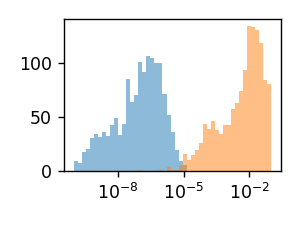

In [47]:
plot_diff(pdB_D_r_vo, nd_D_r[:, sv, so])

至此，我们已经将所有的弛豫密度矩阵导数求完了。`pdB_D_r` $\partial_\mathbb{B} D_{pq}^\mathrm{PT2}$ 表示为

In [48]:
pdB_D_r = pdB_D_r_oovv.copy()
pdB_D_r[:, sv, so] += pdB_D_r_vo
pdB_D_r.shape

(12, 22, 22)

<IPython.core.display.Javascript object>


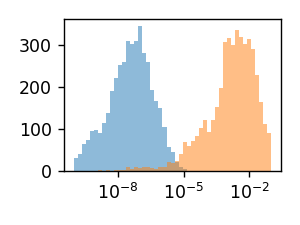

In [49]:
plot_diff(pdB_D_r, nd_D_r)

### 逆向 Z-Vector 方法

这是下述文章所提及的方法：

- **Cammi**

    这篇文档讨论 MP2 的二阶梯度实现。

    > Cammi, R.; Mennucci, B.; Pomelli, C.; Cappelli, C.; Corni, S.; Frediani, L.; Trucks, G. W. & Frisch, M. J.
    >
    > Second-order Møller–Plesset second derivatives for the polarizable continuum model: theoretical bases and application to solvent effects in electrophilic bromination of ethylene 
    >
    > *Theor. Chem. Acc.* **2004**, *111*, 66-77
    >
    > doi: [10.1007/s00214-003-0521-8](https://dx.doi.org/10.1007/s00214-003-0521-8)

我们注意到，我们未必真的要求取 $\partial_\mathbb{B} D_{ai}^\mathrm{MP2}$。我们的计算目标是 $\partial_\mathbb{B} D_{pq}^\mathrm{MP2} \cdot B_{pq}^\mathbb{A}$ 对 $p, q$ 的角标求和，如果不严格地用矩阵的语言描述，就是 $\mathrm{tr} \big( (\partial_\mathbb{B} \mathbf{D}^\mathrm{MP2})^\dagger \mathbf{B}^\mathbb{A} \big)$。

但我们知道，如果我们将 CP-HF 方程写为 $\mathbf{A}' \partial_\mathbb{B} \mathbf{D}^\mathrm{MP2} = \mathtt{RHS}^\mathbb{B}$，那么 $\partial_\mathbb{B} \mathbf{D}^\mathrm{MP2} = (\mathbf{A}')^{-1} \mathtt{RHS}^\mathbb{B}$。因此，

$$
\mathrm{tr} \big( (\partial_\mathbb{B} \mathbf{D}^\mathrm{MP2})^\dagger \mathbf{B}^\mathbb{A} \big)
= \mathrm{tr} \big( (\mathtt{RHS}^\mathbb{B})^\dagger (\mathbf{A}')^{-1} \mathbf{B}^\mathbb{A} \big)
= \mathrm{tr} \big( (\mathtt{RHS}^\mathbb{B})^\dagger \mathbf{U}^\mathbb{A} \big)
$$

我们指出，上述过程的推导与 Z-Vector 方法的推导是相同的，但只是将原先与 Z 矩阵想等价的 $\partial_\mathbb{B} \mathbf{D}^\mathrm{MP2}$ 转化为 $\mathbf{U}^\mathbb{A}$ 的计算。而 Z-Vector 方法本来是要避免 U 矩阵的计算的，因此称为逆向 Z-Vector 方法。

## MP2 相关能二阶核坐标梯度：非安全方法

$$
\begin{align}
\partial_\mathbb{A} \partial_\mathbb{B} E_\mathrm{MP2, c}
&= \partial_\mathbb{B} D_{pq}^\mathrm{MP2, oo-vv} B_{pq}^\mathbb{A} + \mathtt{RHS}_{ai}^\mathbb{B} U_{ai}^\mathbb{A} + D_{pq}^\mathrm{MP2} \cdot \partial_\mathbb{B} B_{pq}^\mathbb{A} \\
&\quad + \partial_\mathbb{B} W_{pq}^\mathrm{MP2} [\mathrm{I}] \cdot S_{pq}^\mathbb{A} + W_{pq}^\mathrm{MP2} [\mathrm{I}] \cdot \partial_\mathbb{B} S_{pq}^\mathbb{A} \\
&\quad + 2 \partial_\mathbb{B} T_{ij}^{ab} \cdot (ia | jb)^\mathbb{A} + 2 T_{ij}^{ab} \cdot \partial_\mathbb{B} (ia | jb)^\mathbb{A}
\end{align}
$$

In [50]:
E_2_MP2_contrib = (
    + np.einsum("Bpq, Apq -> AB", pdB_D_r_oovv, B_1)
    + np.einsum("Bai, Aai -> AB", RHS_B, U_1_vo)
    + np.einsum("pq, ABpq -> AB", D_r, pdB_B_A)
    + np.einsum("Bpq, Apq -> AB", pdB_W_I, S_1_mo)
    + np.einsum("pq, ABpq -> AB", W_I, pdB_S_A_mo)
    + 2 * np.einsum("Biajb, Aiajb -> AB", pdA_T_iajb, eri1_mo[:, so, sv, so, sv])
    + 2 * np.einsum("iajb, ABiajb -> AB", T_iajb, pdB_pdpA_eri0_iajb)
)

In [51]:
np.allclose(E_2_MP2_contrib, hessh._get_E_2_MP2_Contrib())

True